# XAI Recipes for the HuggingFace 🤗 Image Classification Models


## Tutorial

![DFF](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/tutorials/huggingface_dff.png)
### Goal
In this tutorial we will go over all (or most of?) the vision classification model families in the HuggingFace collection, and apply the pytorch gradcam package on each of them.

One of the top repeating questions by users in this package is "How do I apply XAI on model X" ?
The purpose of this tutorial is to cover that completely for existing models, and show enough examples to help users apply this on new even quirkier new models if they need to.

To make XAI a real world practice, we need to be able to work with new (often complex) models that are appearing in lightening speed, and not just simpler CNNs like Resnet or VGG.
With the pytorch_grad_cam package, you have the tools to do that.

Besides, this also gives us a good oppertunity to look into the latest and greatest models from HuggingFace💕.


### Targets and Reshapes are all you need

The Class Activation Map family of algorithms get as an input:
- A model

- An image

- A target function that you want to explain.
e.g: "Where does the model see a Remote Control in this image?"

- A target layer (or layers).
The internal Activations from this layer will be used.
Let's correct the previous bullet:
It's actually - "Where does the model see a Remote Control in these activations from our target layer".

- A reshape function that tells how to to translate the activations, to feature maps of (typically small) 2D images.

### Target Functions
A target function takes the output from the model, and returns the goal we care about.
For multi-class classification it can be: "The logit output for category 761".
That's so common we have a wrapper for it: `ClassifierOutputTarget(761)`, but you can also implement that yourself.

It's really this simple:
```python
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]
```

For classification, usually, the logits, before Softmax, are used.
Softmax makes the categories compete with each other.
The rational is that with the logits you're looking only for positive evidence of a Remote-Control, and not for evidence of what makes it not look like a "Cat".
In some cases it might make sense to use the score after softmax - then you can use ClassifierOutputSoftmaxTarget.

Some other notable implemented targets (in utils.model_targets) are:
SemanticSegmentationTarget, BinaryClassifierOutputTarget, FasterRCNNBoxScoreTarget.

**Important**: In case you have a batch with several images, you need 1 target for each of the images.
This gives us a pattern as you will see below, to apply multiple XAI targets on the same image: just replicate the image and pass a list with several targets.

### Reshapes
For CNNs, the activations are already 2D feature maps with the shape `batch x features x height x width`.
That's what we need, so for them we can just pass `reshape_function=None`.

For transformer variations it often gets a bit more involved.
Several things we need to care about:
- Is there a class token?
Typically the class token will be the first token, followed by the other tokens that correspond with the 2D input patches.
If it exists, we need to get rid of it, to keep only the tokens with the spatial data, i.e those that we can visualize as 2D images.
For example in the Visition Transformer (ViT) reshape function below, that's why we do
```python
activations = x[:, 1:, :]`
```

- Reshaping to features with the format `batch x features x height x width`

Transformers will sometimes have an internal shape that looks like this: (batch=10 x (tokens = 145) x (features=384).
The 145 tokens mean 1 CLS token + 144 spatial tokens.
These 144 spatial tokens actually represent a 12x12 2D image.

And the feautres here are last.. so we need to transpose them to be the second coordinate.

All in all, now we can write our reshape transform:
```python
def reshape_transform_vit_huggingface(x):
    # Remove the CLS token:
    activations = x[:, 1:, :]
    # Reshape to a 12 x 12 spatial image:
    activations = activations.view(activations.shape[0], 12, 12, activations.shape[2])
    # Transpose the features to be in the second coordinate:
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations
```
### GradCAM, that forces us to carefully choose layers that output Tensors, so we can get gradients

Long story short, GradCAM prefers target layers that output tensors, e.g:
```python
model.cvt.encoder.stages[-1].layers[-1]
```
and not
```python
model.vit.encoder
```
that outputs specific HuggingFace wrappers that inherit from ModelOutput

If we would set target_layer=model.vit.encoder we wouldn't get gradients. 
I'm not sure yet why, so if you know why, please open an issue.
I think it could be related to how in HuggingFace the block outputs are typically wrapped with wrappers like `ModelOutput` witch reshape the data into a dictionary. But I tried also tried passing return_dict=False, and got the same.

### How do we know which target layer to chose?
print, print and print the model.
And then if you're still not sure, read the source code of the model you're interested in.
You want the latest layer that's used in the code, just before the pooling / classifier is applied.

And besides, this tutorial + the repository Readme, covers most of the existing Vision Model families, so chances are it has what you need. 

### Wrap your models so they output tensors and not dataclasses or dictionaries
We want to re-use ClassifierOutputTarget, that expects a tensor.
However the hugging face models often output a dataclass that contains a `logits` property.
ClassifierOutputTarget would then break since it expects a tensor..

This is a recurring theme and happens so much that this deserves it's own section. For example object detection models return dictionaries with bounding boxes and categories.

No problem, let's wrap the model:
```python
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits
```

### Lets Go!
We're going to take one of the sample images in HuggingFace, and show how to create:
- GradCAM, for two different categories (the Remote-Control, and the Egyptial Cat category).

For every model we will get a recipie, with it's own target_layer and reshape_transform.
In every recepie section you can see the custom reshape_function, and the target_layers.


## Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional

No config specified, defaulting to: cats-image/image
Found cached dataset cats-image (C:/Users/Jacob Gildenblat/.cache/huggingface/datasets/huggingface___cats-image/image/1.9.0/68fbc793fb10cd165e490867f5d61fa366086ea40c73e549a020103dcb4f597e)


  0%|          | 0/1 [00:00<?, ?it/s]

## Load Dataset, target image and Model

In [ ]:
dataset = load_dataset("../Dataset/yolo_training/cropped_lizard_10000")

In [ ]:
image = dataset["test"]["image"][0]
img_tensor = transforms.ToTensor()(image)

In [ ]:
model_checkpoint = "swin-base-patch4-window12-384-finetuned-lizard-class-swin-base"

## Helper Functions

In [ ]:

""" Model wrapper to return a tensor"""
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

""" Translate the category name to the category index.
    Some models aren't trained on Imagenet but on even larger datasets,
    so we can't just assume that 761 will always be remote-control.

"""
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]
    
""" Helper function to run GradCAM on an image and create a visualization.
    (note to myself: this is probably useful enough to move into the package)
    If several targets are passed in targets_for_gradcam,
    e.g different categories,
    a visualization for each of them will be created.
    
"""
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module=img_tensor,
                          input_image: Image=image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)
    
    
def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0)).logits
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}")

## Execute GradCAM on models

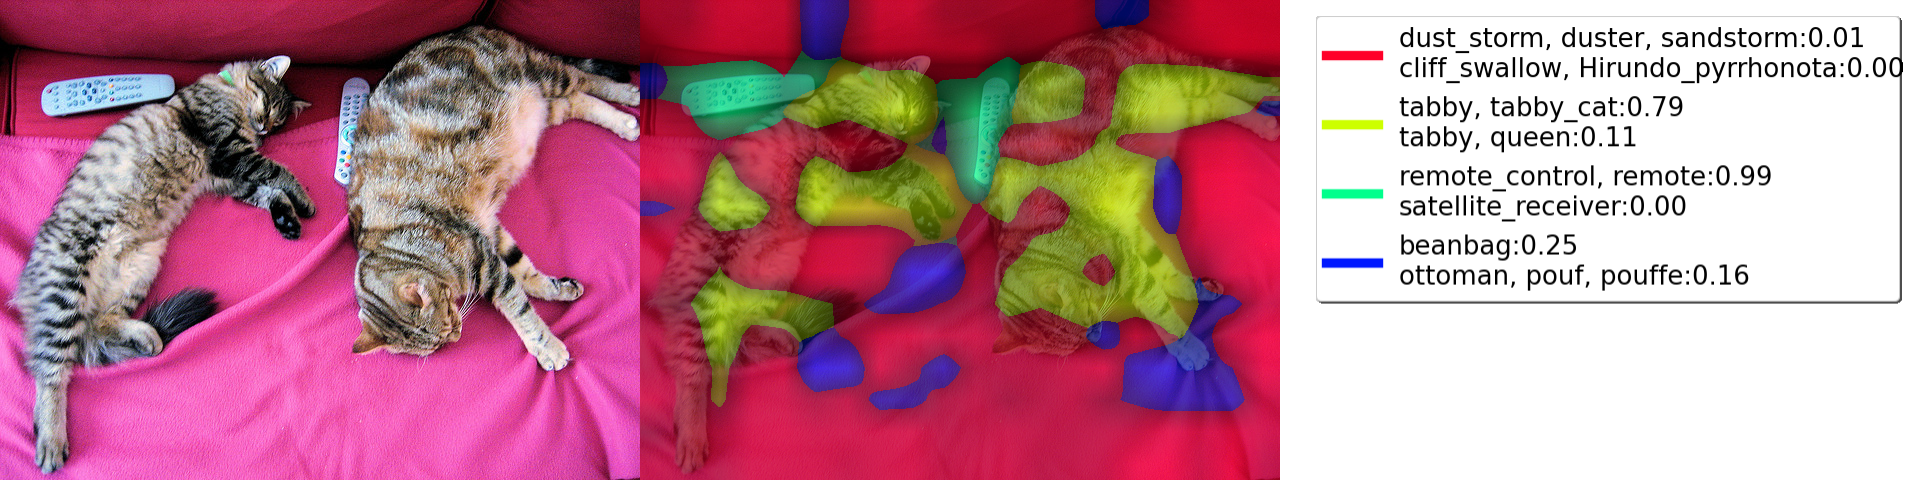

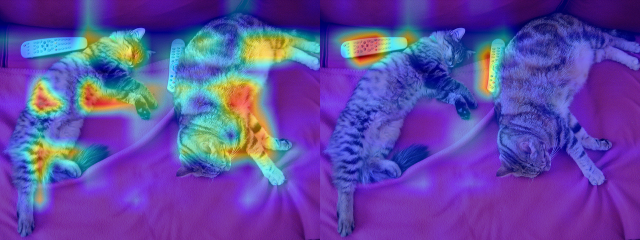

Predicted class 2397: tabby, tabby_cat
Predicted class 2395: tabby, queen
Predicted class 2398: tiger_cat
Predicted class 2388: domestic_cat, house_cat, Felis_domesticus, Felis_catus
Predicted class 2405: Egyptian_cat


In [26]:
from transformers import SwinForImageClassification
from functools import partial
def swinT_reshape_transform_huggingface(tensor, width, height):
    result = tensor.reshape(tensor.size(0),
                            height,
                            width,
                            tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

model = SwinForImageClassification.from_pretrained("microsoft/swin-large-patch4-window12-384-in22k")
target_layer = model.swin.layernorm
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Egyptian_cat")),
                       ClassifierOutputTarget(category_name_to_index(model, "remote_control, remote"))]
reshape_transform = partial(swinT_reshape_transform_huggingface,
                            width=img_tensor.shape[2]//32,
                            height=img_tensor.shape[1]//32)

display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer,
                          classifier=model.classifier,
                          img_pil=image,
                          img_tensor=img_tensor,
                          reshape_transform=reshape_transform,
                          n_components=4,
                          top_k=2)))
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer,
                      targets_for_gradcam=targets_for_gradcam,
                      reshape_transform=reshape_transform)))
print_top_categories(model, img_tensor)

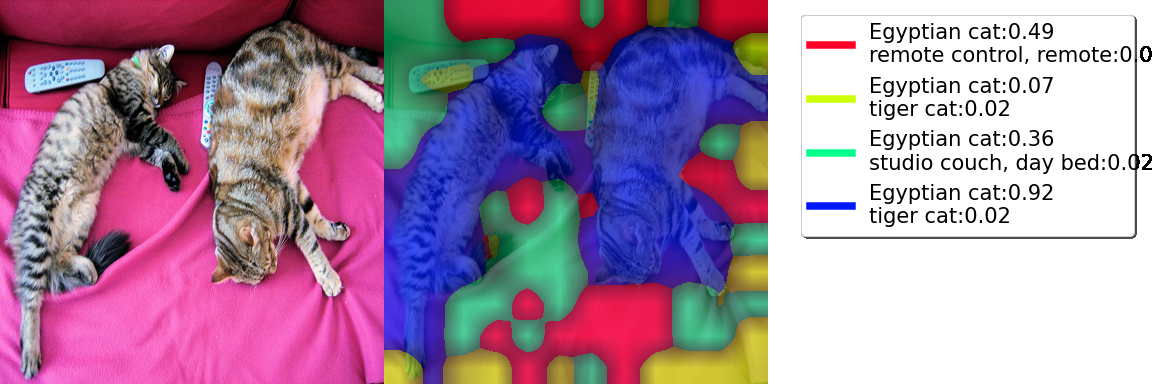

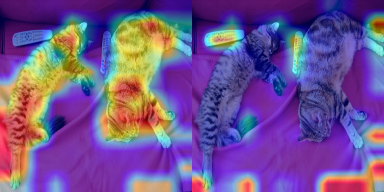

Predicted class 285: Egyptian cat
Predicted class 282: tiger cat
Predicted class 281: tabby, tabby cat
Predicted class 761: remote control, remote
Predicted class 287: lynx, catamount


In [30]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
def reshape_transform_vit_huggingface(x):
    activations = x[:, 1:, :]
    activations = activations.view(activations.shape[0],
                                   12, 12, activations.shape[2])
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations

model = ViTForImageClassification.from_pretrained('google/vit-large-patch32-384')
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Egyptian cat")),
                       ClassifierOutputTarget(category_name_to_index(model, "remote control, remote"))]
target_layer_dff = model.vit.layernorm
target_layer_gradcam = model.vit.encoder.layer[-2].output
image_resized = image.resize((384, 384))
tensor_resized = transforms.ToTensor()(image_resized)


display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer_dff,
                          classifier=model.classifier,
                          img_pil=image_resized,
                          img_tensor=tensor_resized,
                          reshape_transform=reshape_transform_vit_huggingface,
                          n_components=4,
                          top_k=2)))
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer_gradcam,
                      targets_for_gradcam=targets_for_gradcam,
                      input_tensor=tensor_resized,
                      input_image=image_resized,
                      reshape_transform=reshape_transform_vit_huggingface)))
print_top_categories(model, tensor_resized)